# Monte Carlo for the rescaled radiative transfer implemented in Julia

## Arnold D. Kim
*Department of Applied Mathematics, University of California, Merced*

In [1]:
# include packages used in these codes

using Dates, DelimitedFiles, SpecialFunctions, FastGaussQuadrature, PyPlot, LaTeXStrings

In [2]:
# give the current day and time to show last update to the code

println( "Last updated: ", Dates.now() )

Last updated: 2024-07-16T07:18:11.250


## Description

This Jupyter notebook contains the Julia implementation of a Monte Carlo simulation method to solve the following boundary value problem for the *rescaled* radiative transfer equation,
\begin{equation}
    \hat{\mathbf{s}} \cdot \nabla I = -\epsilon \left[ I - \varpi_{0} \int_{4\pi} p(\hat{\mathbf{s}} \cdot \hat{\mathbf{s}}') 
    I(\hat{\mathbf{s}}',\mathbf{r}) \mathrm{d}\hat{\mathbf{s}}' \right], \quad \text{in $z > 0$}, \quad 0 < \epsilon \ll 1,
\end{equation}
subject to the boundary condition,
\begin{equation}
    I(\hat{\mathbf{s}},x,y,0) = \delta(\hat{\mathbf{s}} - \hat{z}) 
    \frac{2}{\pi} e^{-2 (x^{2} + y^{2})}
    + \mathcal{R}[I](\hat{\mathbf{s}},x,y,0), 
    \quad \text{on $\hat{\mathbf{s}} \cdot \hat{z} > 0$}.
\end{equation}
Here, $p$ is the phase function, $\varpi_{0} = \mu_{s}/(\mu_{s} + \mu_{a})$ is the albedo and $\mathcal{R}$ is the operator corresponding to reflection at the boundary due to a refractive index mismatch. Note that in this formulation of radiative transfer, the spatial variables are scaled by the width of the collimated beam, $w$. In this rescaling we have introduced $\epsilon = w (\mu_{s} + \mu_{a})$ and are assuming that $w$ is the smallest length scale in the problem.

In these simulations, $p(\hat{\mathbf{s}} \cdot \hat{\mathbf{s}}')$ is the Henyey-Greenstein phase function,
\begin{equation}
    p(\cos\Theta) = \frac{1}{4\pi} \frac{1 - g^{2}}{(1 + g^{2} - 2 g \cos\Theta )^{3/2}},
\end{equation}
with $g$ denoting the anisotropy factor.

## Monte Carlo simulations

The Julia code below is based off of the Monte Carlo Simulation Package, MCML, described in the following references.

1. Wang, L. V.; Jacques, S. L.; Zheng, L. Q.; "MCML — Monte Carlo modeling of light transport in multilayered tissues," Computer Methods and Programs in Biomedicine 47(2) 131-146 (1995)

2. Jacques, S. L.; Wang, L. V.; "Monte Carlo modeling of light transport in tissues," Optical Thermal Response of Laser Irradiated Tissue 73–100 (1995)

This implementation is specific to this particular problem and is not meant as a general purpose code.

## Common Monte Carlo functions

The codes below define functions that are extensively used by the Monte Carlo simulations.

### Function: RFresnel

Compute the Fresnel reflection coefficient for upolarized light.

NOTE: This code is a direct translation of the code appearing in MCML.

In [3]:
function RFresnel( n1, n2, ca1 )

    if n1 == n2
        
        r = 0.0;
        
    elseif ca1 > 1.0 - 1e-12
        
        r  = ( n2 - n1 ) / ( n2 + n1 );
        r *= r;
    
    elseif ca1 < 1e-6
        
        r = 1.0;
        
    else
        
        sa1 = sqrt( 1.0 - ca1 * ca1 );
        sa2 = n1 * sa1 / n2;

        if sa2 >= 1.0
            
            # double check for total internal reflection

            r = 1.0;
            
        else

            ca2 = sqrt( 1.0 - sa2 * sa2 );
            cap = ca1 * ca2 - sa1 * sa2; 
            cam = ca1 * ca2 + sa1 * sa2;
            sap = sa1 * ca2 + ca1 * sa2;
            sam = sa1 * ca2 - ca1 * sa2;

            r = 0.5 * sam * sam * ( cam * cam + cap * cap ) / 
                ( sap * sap * cam * cam ); 
            
        end
        
    end
    
    return r;
    
end

RFresnel (generic function with 1 method)

### Function: AdvancePhoton

This function updates the location of the photon and checks if it has interacted with the boundary plane $z = 0$.

In [4]:
function AdvancePhoton( ℓinv, pos, dir, wt, n1, n2, dρ, Nρ, flux )

    # set the iexit flag to continue with the simulation
    
    iexit = 0;
    
    # compute the step length
    
    Δs = - log( rand( Float64 ) ) / ℓinv;

    # update the location using the computed step length
    
    pos += dir * Δs;

    # check if the photon has escaped from the top

    if pos[3] <= 0 # from the boundary plane z = 0

        # compute random number

        ξ = rand( Float64 );

        # Fresnel reflection

        if ξ > RFresnel( n1, n2, -dir[3] );

            # set iexit flag to terminate the simulation

            iexit = 1;

            # back up to the previous location

            pos -= dir * Δs;

            # propagate up to z = 0 plane

            pos += dir * abs( pos[3] / dir[3] );

            # record contribution to reflectance

           ir = floor( Int, sqrt( pos[1]^2 + pos[2]^2 ) / dρ ) + 1;

            if ir < Nρ

                flux[ir] += wt;

            else

                flux[Nρ] += wt;

            end

        else

            # set iexit flag to continue the simulation

            iexit = 0;

            # reflection by Snell's law

            pos[3] = -pos[3];
            dir[3] = -dir[3];

        end

    end
    
    return iexit, pos, dir, wt, flux;
    
end

AdvancePhoton (generic function with 1 method)

### Function: UpdateDirection

This function updates the components of the direction vector given the result of the cosine of the scattering angle sampled from the phase function..


In [5]:
function UpdateDirection( dir, cosθ )

    # compute the sine of the scattering angle
    
    sinθ = sqrt( 1.0 - cosθ * cosθ );

    # compute the azimuthal angle
    
    ϕ = 2π * rand( Float64 );
    
    # compute the cosine and sine of the azimuthal angle

    cosϕ = cos( ϕ );

    if ϕ < 1π

        sinϕ = sqrt( 1.0 - cosϕ * cosϕ );

    else

        sinϕ = -sqrt( 1.0 - cosϕ * cosϕ );

    end
    
    # update the components of the direction vector s = (u,v,w)

    if 1.0 - dir[3] <= 1e-12

        u = sinθ * cosϕ;
        v = sinθ * sinϕ;
        w = cosθ * sign( dir[3] );

    else

        temp = sqrt( 1.0 - dir[3]^2 );

        u =  sinθ * ( dir[1] * dir[3] * cosϕ - dir[2] * sinϕ ) / temp + 
            dir[1] * cosθ;
        v =  sinθ * ( dir[2] * dir[3] * cosϕ + dir[1] * sinϕ ) / temp + 
            dir[2] * cosθ; 
        w = -sinθ * cosϕ * temp + dir[3] * cosθ;

    end
    
    dir[1] = u;
    dir[2] = v;
    dir[3] = w;    
    
    return dir;
    
end

UpdateDirection (generic function with 1 method)

### Function: Absorption

This function modifies the weight according to absorption in the medium.

In [6]:
function Absorption( ϖ0, wt )

    # compute the absorption
    
    absorb = wt * ( 1.0 - ϖ0 );
    
    # adjust the weight
    
    wt -= absorb;
    
    return wt;
    
end

Absorption (generic function with 1 method)

### Function: Roulette

This function performs the Russian Roulette algorithm to determine the fate of a photon once the weight becomes sufficiently small.

In [7]:
function Roulette( wt )

    # set the chance parameter
    
    chance = 1e-1;
    
    if rand( Float64 ) < chance
        
        # set the iexit flag value to continue simulating
        
        iexit = 0;
        
        wt /= chance;
                
    else
        
        # set the iexit flag value to terminate simulation
        
         iexit = 3;
                
    end
    
    return iexit, wt;
    
end

Roulette (generic function with 1 method)

## MAIN MC FUNCTION

The following function is the main function used to compute the solution of the radiative transfer equation in the semi-infinite medium $z > 0$ using Monte Carlo simulations. This function calls the Common MC functions above.

In [8]:
function MCHalfSpaceHG( ℓinv, ϖ0, g, n1, n2, ρMAX, Nρ, N )

   # compute the souce-detector separation distances
   
   Δρ = ρMAX / Nρ;
   ρ  = Float64[ ( j - 0.5 ) * Δρ for j = 1 : Nρ ];

   # allocate memory for the flux (diffuse reflectance)
   
   flux = Float64[ 0.0 for j = 1 : Nρ ];

   # initialize position and direction vectors

   pos = Array{Float64}(undef,3);
   dir = Array{Float64}(undef,3);

   # loop over all photons

   for i = 1 : N
    
      # initialize the photon
    
      pos[1] = sqrt( -log( rand(Float64) ) / 2.0 );
      pos[2] = 0.0;
      pos[3] = 0.0;
    
      dir[1] = 0.0;
      dir[2] = 0.0;
      dir[3] = 1.0;    
    
      wt = 1.0;
    
      iexit = 0;

      while iexit == 0
       
         # advance the photon and check to see if it has escaped the domain
        
         iexit, pos, dir, wt, flux = AdvancePhoton( ℓinv, pos, dir, wt, n1, n2, Δρ, Nρ, flux );  
        
         # update the weight due to absorption
        
         wt = Absorption( ϖ0, wt );
        
         # scatter the photon accoring to Henyey-Greenstein

         η = ( 1.0 - g * g ) / ( 1.0 - g + 2.0 * g * rand( Float64 ) );
         μ = ( 1.0 + g * g - η^2 ) / ( 2.0 * g );
            
         # update the components of the direction vector

         dir = UpdateDirection( dir, μ );

         # roulette (threshold set to 1e-4)
        
         if wt < 1e-4
                    
            iexit, wt = Roulette( wt );
            
         end
    
      end

   end

   # normalize the flux

   flux = flux ./ ( 2π * ρ * Δρ * N );

   return ρ, flux;

end

MCHalfSpaceHG (generic function with 1 method)

# Compute MC Simulation Results

With the functions defined above, we can specify the problem we wish to solve.

In [22]:
# absorption coefficient

μa = 1.00;

# scattering coefficient

μs = 100.0;

# total coefficient

μt = μs + μa;

# epsilon

ϵ = 0.01;

# albedo

ϖ0 = μs / μt;

# anisotropy factor

g  = 0.90;

# refractive indices

n1 = 1.38; # inside the medium
n2 = 1.00; # outside the medium

# radial grid

ρMAX = 2000.0;
Nρ   = 201;

# number of photons

N  = 1e6;

# compute the diffuse reflectance using MC simulations

ρ, flux = @time MCHalfSpaceHG( ϵ, ϖ0, g, n1, n2, ρMAX, Nρ, N );

 61.736814 seconds (826.19 M allocations: 61.556 GiB, 14.61% gc time, 0.00% compilation time)


# Asymptotic approximation for the reflectance

In the codes that follow, we compute the following asymptotic approximation for the reflectance,
\begin{equation}
   R(\rho) = \epsilon \varpi_{0} \mathscr{I}[p] \frac{ 1 + \text{erf}( \sqrt{2} \rho )}{2 \rho},
\end{equation}
where
\begin{equation}
   \mathscr{I}[p] = -\int_{\pi/2}^{\pi} T_{F}(\theta) \frac{p(\cos\vartheta(\theta))}{\sin \vartheta(\theta)} \cos\theta \sin\theta \mathrm{d}\theta
\end{equation}
is called the influence integral. To account for a refractive index mismatch at the boundary, we use $\vartheta(\theta) = \arcsin( n^{-1} \sin\theta )$ where $n = n_{2}/n_{1}$ denotes the relative refractive index, and use the Fresnel transmission coefficient,
\begin{equation}
   T_{F}(\theta) = \frac{\cos\theta}{2 n^{3} \cos\vartheta(\theta)} 
   \left[ \left( \frac{2 n \cos \vartheta(\theta)}{\cos\vartheta(\theta) + n \cos\theta } \right)^{2} 
   + \left( \frac{2 n \cos \vartheta(\theta)}{n \cos\vartheta(\theta) + \cos\theta } \right)^{2} \right].
\end{equation}

In [23]:
# compute Gauss-Legendre quadrature rule

M = 32;
μ, wt = gausslegendre( M );

# map quadrature rule to [-1,0)

μ  = 0.5 .* ( μ .- 1.0 );
wt = 0.5 .* wt;

# compute the refracted angles

nrel = n1 / n2;
ϑ    = -sqrt.( 1.0 .- ( 1.0 .- μ.^2 ) / nrel^2 );

# compute the integral in μ

influence_integral = 0.0;

for im = 1 : M

    # compute the Fresnel transmission coefficient
    
    FresnelT = μ[im] / ( 2.0 * nrel^3 * ϑ[im] ) * 
        ( ( 2.0 * nrel * ϑ[im] / ( ϑ[im] + nrel * μ[im] ) )^2 + 
          ( 2.0 * nrel * ϑ[im] / ( nrel * ϑ[im] + μ[im] ) )^2 );
    
    # compute the phase function

    pHG = ( 1.0 - g * g ) / sqrt( 1.0 + g * g - 2.0 * g * ϑ[im] )^3 / 4π;
    
    # update the integral
    
    influence_integral -= FresnelT * pHG * μ[im] / sqrt( 1.0 - ϑ[im]^2 ) * wt[im];
    
end

# evaluate the leading asymptotic behavior of the reflectance

asymptotic_approximation = ϵ * ϖ0 * influence_integral .* ( 1.0 .+ erf.( sqrt( 2.0 ) * ρ ) ) ./ ( 2.0 .* ρ );

# Plot the results

We plot the results for the diffuse reflectance and compare them with asymptotic approximation.

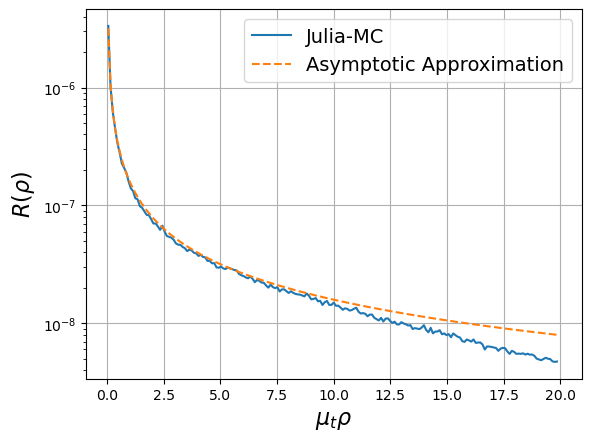

In [24]:
semilogy( ϵ * ρ[1:end-1], flux[1:end-1], linestyle = "-" );
semilogy( ϵ * ρ, asymptotic_approximation, linestyle = "--" );
grid( "on" );
xlabel( L"$\mu_{t} \rho$", fontsize = 16 );
ylabel( L"$R(\rho)$", fontsize = 16 );
legend( [ "Julia-MC", "Asymptotic Approximation" ], fontsize = 14 );

We also plot the absolute difference between the two results.

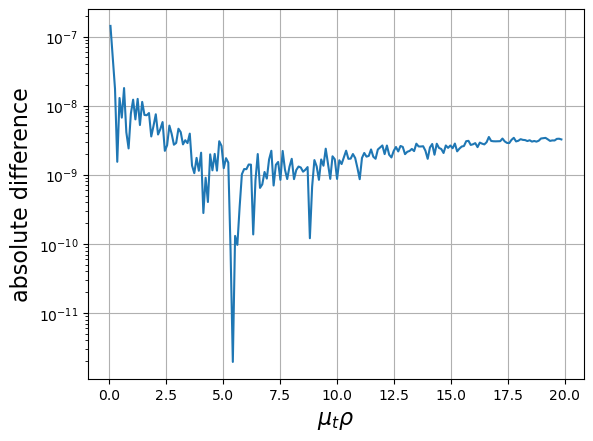

In [25]:
semilogy( ϵ * ρ[1:end-1], abs.( flux[1:end-1] - asymptotic_approximation[1:end-1] ) );
grid( "on" );
xlabel( L"$\mu_{t} \rho$", fontsize = 16 );
ylabel( "absolute difference", fontsize = 16 );